In [2]:
##Load all the required libraries...

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
import time
import pandas as pd
import copy

from tools.base import *
from tools.ddmtd import ddmtd
from time import sleep

In [3]:
import matplotlib
matplotlib.style.available
# import scienceplots
# matplotlib.style.use(['seaborn-v0_8-darkgrid', 'science'])
# plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 300

In [7]:
print(hex(2147505923))
print(bin(2147505923))
print(2147505923 - 2**31)
print(bin(1070850))

0x80005703
0b10000000000000000101011100000011
22275
0b100000101011100000010


In [4]:
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [4]:
# Setting all the variables...
N=100000  #Setting the DDMTD N
freq="160"#in MHz #Setting the input clock frequency
pll_config_folder="../rpi_side/PLL_Conf/"
fig_save_folder = f"./dcps3Test/figures/N{N}/"
data_save_folder_fine = f"./dcps3Test/data/N{N}_fine/"
data_save_folder = f"./dcps3Test/data/N{N}/"
!mkdir -p {fig_save_folder} #create those directories
!mkdir -p {data_save_folder} #create those directories
run = 0
coarse_control = 0
fine_control = 0
stage4_tune = 2
stage5_tune = 3
channel = 3
run_name = f"chan{channel}_f{fine_control}_c{coarse_control}_s4{stage4_tune}_s5{stage5_tune}_run{run}"

The syntax of the command is incorrect.
The syntax of the command is incorrect.


In [5]:
dat = []
uhoh = []
f = plt.figure(figsize=(10, 15))
f.subplots_adjust(top=0.98, bottom=0.03, hspace=0.4, wspace=0.3)
for channel in range (2, 4, 1):
    if channel == 2:
        i = 1
    else:
        i = 2
    for stage4_tune in range (2, 4, 1):
        for stage5_tune in range (2, 4, 1):
            dat = []
            for k, coarse_control in enumerate(range(0,32,1)):
                run_name = f"chan{channel}_f{fine_control}_c{coarse_control}_s4{stage4_tune}_s5{stage5_tune}"
                df1 = pd.read_csv(f"{data_save_folder+run_name}_ddmtd1.txt",names=['edge1','ddmtd1'])
                df2 = pd.read_csv(f"{data_save_folder+run_name}_ddmtd2.txt",names=['edge2','ddmtd2'])
                df = pd.concat((df1,df2),axis=1)
                # df

                # df.ddmtd2.diff().iloc[:].plot()
                # df.ddmtd1.diff().iloc[:].plot()


                # Create a DDMTD Object for analysis of the data
                data = ddmtd(df.iloc[:,:],channel=(1,2),q=1) #creates a ddmtd object
                #Setting the correct N can recalculating all the scalings
                data.N = N  
                # data.N = 1000000 
                data.INPUT_FREQ = 160*10**6 #In Hz 
                data.Recalc()
                mean_val = np.mean(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
                # print(
                # # np.mean(data.TIE_fall)*data.MULT_FACT*1000,
                # # np.mean(data.TIE_rise)*data.MULT_FACT*1000,
                # np.mean(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
                # )

                dat.append((coarse_control,mean_val))

            dat = np.asarray(dat)
            x = dat.T[0]
            y = -1*(dat.T[1]+200)%3125

            y = y-y[0]

            # x = x[:(len(x) - 1)]
            # y = y[:(len(y) - 1)]
            ax = f.add_subplot(int(f"42{i}"))
            # fit
            truth = []
            for j, val in enumerate(copy.deepcopy(y)):
                if val < 0:
                    uhoh.append((j, i))
                    truth.append(False)
                else:
                    truth.append(True)
            
            x = x[truth]
            y = y[truth]

            # print(f"\n\n\n PLOT NUMBER {i}\n")
            # print(f"X VALUE\n---------------\n{x}")
            # print(f"\n\nY VALUE\n---------------\n{y}\n\n")
            # print(y[25])

            popt,pcov = np.polyfit(x,y,1,cov=True)
            _, residuals, _, _, _ = np.polyfit(x, y, 1, full=True)
            p_e = np.sqrt(np.diag(pcov))
            reduced_chi_squared = residuals / (len(x) - 2)

            #print(f"\nResiduals: {residuals}\n\nReduced chi-squared: {residuals / (len(x) - 2)}\np_e: {p_e}\n\np_e times dof: {p_e * (len(x) - 2)}\n")

            ax.plot(x,popt[0]*x+popt[1],color="r",linestyle='--',label=f"Channel {channel} \n{popt[0]:4.3}+/- {p_e[0]:4.2} [ps/step]\nReduced \u03C7\u00B2: {reduced_chi_squared[0]:.3f}")

            plt.scatter(x,y,s=6)

            ax.set_ylim([0, 250])
            ax.set_ylabel("Delay [ps]")
            ax.set_xlabel("Coarse Step")
            ax.legend(loc="upper left",fontsize=10)
            ax.set_title(f"Coarse Delay Channel {channel}: {stage4_tune} {stage5_tune}")

            if i == 3 or i == 4:
                bounds = ax.axis()
                print(bounds)
                rec = plt.Rectangle((bounds[0] - 7, bounds[2] - 50), width=bounds[1]-bounds[0] + 9, height=bounds[3]-bounds[2] + 85, fill=False, lw=1, edgecolor="red")
                rec = ax.add_patch(rec)
                rec.set_clip_on(False)
            
            i += 2
plt.savefig("dcps3Test/figures/dcps3_coarse_test_removed_outliers_rchi2.png", dpi=300, facecolor="#FFFFFF")
plt.close()

(-1.55, 32.55, 0.0, 250.0)
(-1.55, 32.55, 0.0, 250.0)


In [8]:
uhoh = []
dat = []
dat2 = []
f = plt.figure(figsize=(10,4))
f.subplots_adjust(wspace=0.3)
fine_control = 0
for channel in range (2, 4, 1):
    dat2 = []
    for run in range(10):
        dat = []
        for k, coarse_control in enumerate(range(0,32,1)):
            run_name = f"chan{channel}_f{fine_control}_c{coarse_control}_s4{stage4_tune}_s5{stage5_tune}_run{run}"
            df1 = pd.read_csv(f"{data_save_folder+run_name}_ddmtd1.txt",names=['edge1','ddmtd1'])
            df2 = pd.read_csv(f"{data_save_folder+run_name}_ddmtd2.txt",names=['edge2','ddmtd2'])
            df = pd.concat((df1,df2),axis=1)
            # df

            # df.ddmtd2.diff().iloc[:].plot()
            # df.ddmtd1.diff().iloc[:].plot()


            # Create a DDMTD Object for analysis of the data
            data = ddmtd(df.iloc[:,:],channel=(1,2),q=1) #creates a ddmtd object
            #Setting the correct N can recalculating all the scalings
            data.N = N  
            # data.N = 1000000 
            data.INPUT_FREQ = 160*10**6 #In Hz 
            data.Recalc()
            #mean_val = np.mean(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
            #std_dev = np.std(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
            #if coarse_control == 13:
            fit, _, _ = data.drawTIE(sep='',fit=True,draw=False)
            mean_val, std_dev = fit[1]*1000, abs(fit[2])*1000

            dat.append((coarse_control,mean_val,std_dev))

        dat = np.asarray(dat)
        x = dat.T[0]
        y = -1*(dat.T[1]+200)%3125
        yerr = -1*(dat.T[2]+200)%3125

        y = y-y[0]

        # x = x[:(len(x) - 1)]
        # y = y[:(len(y) - 1)]
        
        # fit
        truth = []
        for j, val in enumerate(copy.deepcopy(y)):
            if val < 0:
                uhoh.append((channel, run, j))
                truth.append(False)
            else:
                truth.append(True)
        
        x = x[truth]
        y = y[truth]
        yerr = yerr[truth]

        popt,pcov = np.polyfit(x,y,1,cov=True,w=1/yerr**2)
        p_e = np.sqrt(np.diag(pcov))

        dat2.append((run, popt[0], p_e[0]))

        #ax.plot(x,popt[0]*x+popt[1],color="r",linestyle='--',label=f"Channel {channel} \n{popt[0]:4.3}+/- {p_e[0]:4.2} [ps/step]\nReduced \u03C7\u00B2: {reduced_chi_squared[0]:.3f}")

        #plt.scatter(x,y,s=6)
    
    dat2 = np.asarray(dat2)
    x = dat2.T[0]
    y = dat2.T[1]
    yerr = dat2.T[2]

    weighted_mean = np.average(y, weights=1/yerr**2)
    _sig = np.std(y)

    # popt,pcov = np.polyfit(x,y,0,cov="unscaled",w=1/yerr**2)
    # p_e = np.sqrt(np.diag(pcov))

    # weighted_mean = popt[0]
    # _sig = p_e[0]


    ax = f.add_subplot(int(f"12{channel-1}"))
    ax.grid(True, alpha=0.5)
    ax.axhline(y=weighted_mean, color='black',linewidth=1, linestyle='-.',label=f"Mean Delay Slope All Runs\n{weighted_mean:4.3}+/-{_sig:4.2} [ps/step]")
    ax.fill_between(x, weighted_mean+_sig, weighted_mean-_sig, color='orange', alpha=.5, label="\u03c3 All Runs")
    ax.errorbar(x, y, yerr=yerr, fmt='r.', ecolor="black", capsize=2, label=f"Delay per Coarse Step")

    ax.set_ylim([7.1, 7.22])
    
    ax.set_ylabel("Delay per Coarse Step [ps/step]")
    ax.set_xlabel("Run Number")
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(10))
    ax.legend(loc="upper left",fontsize=8)
    ax.set_title(f"Coarse Delay Consistency Check\nChannel {channel}: {stage4_tune} {stage5_tune}")
plt.savefig("dcps3Test/figures/dcps3_coarse_consistency_test.png", dpi=300, facecolor="#FFFFFF")
plt.close()

In [9]:
with open("./dcps3Test/data/bad_files_coarse.txt", "w") as fp:
    for channel, run, coarse_control in uhoh:
        run_name = f"chan{channel}_f0_c{coarse_control}_s42_s53_run{run}"
        fp.write(f"[{data_save_folder+run_name}_ddmtd1.txt] is messed up\n")

In [34]:
# dat = np.asarray(dat)
# x = dat.T[0]
# y = -1*(dat.T[1]+200)%3125
# y = y-y[0]

# # x = x[:(len(x) - 1)]
# # y = y[:(len(y) - 1)]

# f,ax = plt.subplots()
# # fit
# popt,pcov = np.polyfit(x,y,1,cov=True)
# p_e = np.sqrt(np.diag(pcov))
# ax.plot(x,popt[0]*x+popt[1],color="r",linestyle='--',label=f"Channel {channel} \n{popt[0]:4.3}+/- {p_e[0]:4.2} [ps/step]")

# plt.scatter(x,y,s=6)

# ax.set_ylim([0, 248])
# ax.set_ylabel("Delay [ps]")
# ax.set_xlabel("Coarse Step")
# ax.legend(loc="upper left",fontsize=10)
# ax.set_title(f"Coarse Delay Channel {channel}: S4 tune: {stage4_tune} S5 tune: {stage5_tune}")

In [21]:
# Check to see if bit flip technique works.
coarse_files = []
fine_files = []
with open("./dcps3Test/data/bad_files_coarse.txt", "r") as fp:
    for line in fp.readlines():
        coarse_files.append(line[1:].split("]")[0].split("_ddmtd1.txt")[0])
with open("./dcps3Test/data/bad_files_fine.txt", "r") as fp:
    for line in fp.readlines():
        fine_files.append(line[1:].split("]")[0].split("_ddmtd1.txt")[0])
print(coarse_files)
print(fine_files)

['./dcps3Test/data/N100000/chan3_f0_c13_s42_s53_run4', './dcps3Test/data/N100000/chan3_f0_c21_s42_s53_run8', './dcps3Test/data/N100000/chan3_f0_c28_s42_s53_run8']
['./dcps3Test/data/N100000_fine/chan2_f10_c0_s42_s53_run0', './dcps3Test/data/N100000_fine/chan2_f49_c0_s42_s53_run1', './dcps3Test/data/N100000_fine/chan2_f45_c0_s42_s53_run5', './dcps3Test/data/N100000_fine/chan2_f0_c0_s42_s53_run6', './dcps3Test/data/N100000_fine/chan2_f56_c0_s42_s53_run7', './dcps3Test/data/N100000_fine/chan2_f59_c0_s42_s53_run8', './dcps3Test/data/N100000_fine/chan3_f51_c0_s42_s53_run0', './dcps3Test/data/N100000_fine/chan3_f59_c0_s42_s53_run0', './dcps3Test/data/N100000_fine/chan3_f0_c0_s42_s53_run1', './dcps3Test/data/N100000_fine/chan3_f12_c0_s42_s53_run1', './dcps3Test/data/N100000_fine/chan3_f5_c0_s42_s53_run2', './dcps3Test/data/N100000_fine/chan3_f59_c0_s42_s53_run4', './dcps3Test/data/N100000_fine/chan3_f28_c0_s42_s53_run8', './dcps3Test/data/N100000_fine/chan3_f35_c0_s42_s53_run9']


In [72]:
# Bit flips in coarse delays

stage4_tune = 2
stage5_tune = 3
fine_control = 0
coarse_control = 0
stats = []

for file in coarse_files:
    channel = file.split("_")[0][-1]
    run = file.split("_")[-1][-1]
    stats.append((channel, run))

stats_set = []
[stats_set.append(x) for x in stats if x not in stats_set]

k = 1
f = plt.figure(figsize=(10,4*len(stats_set)))
f.subplots_adjust(wspace=0.3, hspace=0.4)
for channel, run in stats_set:
    for bit_flip in range(2):
        dat = []
        for coarse_control in range(32):
            run_name = f"chan{channel}_f{fine_control}_c{coarse_control}_s4{stage4_tune}_s5{stage5_tune}_run{run}"
            df1 = pd.read_csv(f"{data_save_folder+run_name}_ddmtd1.txt",names=['edge1','ddmtd1'])
            df2 = pd.read_csv(f"{data_save_folder+run_name}_ddmtd2.txt",names=['edge2','ddmtd2'])
            df = pd.concat((df1,df2),axis=1)

            if bit_flip:
                for i, val in enumerate(df.ddmtd1):
                    if val > 2e9:
                        new_val = (val ^ 0b10000000000000000000000000000000)
                        #new_vals.append((val, new_val))
                        df.ddmtd1 = df.ddmtd1.replace(val, new_val)
                #print(df.ddmtd1[3])


            # Create a DDMTD Object for analysis of the data
            data = ddmtd(df.iloc[:,:],channel=(1,2),q=1) #creates a ddmtd object
            #Setting the correct N can recalculating all the scalings
            data.N = N  
            # data.N = 1000000 
            data.INPUT_FREQ = 160*10**6 #In Hz 
            data.Recalc()
            #mean_val = np.mean(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
            #std_dev = np.std(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
            #if coarse_control == 13:
            fit, _, _ = data.drawTIE(sep='',fit=True,draw=False)
            mean_val, std_dev = fit[1]*1000, abs(fit[2])*1000

            dat.append((coarse_control,mean_val,std_dev))
        
        dat = np.asarray(dat)
        x = dat.T[0]
        y = -1*(dat.T[1]+200)%3125
        yerr = -1*(dat.T[2]+200)%3125

        y = y-y[0]

        popt,pcov = np.polyfit(x,y,1,cov=True)
        p_e = np.sqrt(np.diag(pcov))

        ax = f.add_subplot(len(stats_set), 2, k)

        ax.plot(x,popt[0]*x+popt[1],color="r",linestyle='--',label=f"Channel {channel} \n{popt[0]:4.3}+/- {p_e[0]:4.2} [ps/step]")

        ax.scatter(x,y,s=6)

        #ax.set_ylim([0, 250])
        ax.set_ylabel("Delay [ps]")
        ax.set_xlabel("Coarse Step")
        ax.legend(loc="best",fontsize=10)
        if bit_flip:
            word = "After"
        else:
            word = "Before"
        ax.set_title(f"Coarse Delay Channel {channel}: {stage4_tune} {stage5_tune}\n Run {run} {word} Bit Flip")
        k += 1
plt.savefig("dcps3Test/figures/dcps3_coarse_bitflip_test.png", dpi=300, facecolor="#FFFFFF")
plt.close()


In [74]:
# Bit flips in fine delays

stage4_tune = 2
stage5_tune = 3
fine_control = 0
coarse_control = 0
stats = []

for file in fine_files:
    channel = file.split("_")[1][-1]
    run = file.split("_")[-1][-1]
    stats.append((channel, run))

stats_set = []
[stats_set.append(x) for x in stats if x not in stats_set]

k = 1
f = plt.figure(figsize=(10,4*len(stats_set)))
f.subplots_adjust(top=0.98, bottom=0.03, hspace=0.4, wspace=0.3)
for channel, run in stats_set:
    for bit_flip in range(2):
        dat = []
        for fine_control in range(66):
            run_name = f"chan{channel}_f{fine_control}_c{coarse_control}_s4{stage4_tune}_s5{stage5_tune}_run{run}"
            df1 = pd.read_csv(f"{data_save_folder_fine+run_name}_ddmtd1.txt",names=['edge1','ddmtd1'])
            df2 = pd.read_csv(f"{data_save_folder_fine+run_name}_ddmtd2.txt",names=['edge2','ddmtd2'])
            df = pd.concat((df1,df2),axis=1)

            if bit_flip:
                for i, val in enumerate(df.ddmtd1):
                    if val > 2e9:
                        new_val = (val ^ 0b10000000000000000000000000000000)
                        #new_vals.append((val, new_val))
                        df.ddmtd1 = df.ddmtd1.replace(val, new_val)
                #print(df.ddmtd1[3])


            # Create a DDMTD Object for analysis of the data
            data = ddmtd(df.iloc[:,:],channel=(1,2),q=1) #creates a ddmtd object
            #Setting the correct N can recalculating all the scalings
            data.N = N  
            # data.N = 1000000 
            data.INPUT_FREQ = 160*10**6 #In Hz 
            data.Recalc()
            #mean_val = np.mean(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
            #std_dev = np.std(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
            fit, _, _ = data.drawTIE(sep='',fit=True,draw=False)
            mean_val, std_dev = fit[1]*1000, abs(fit[2])*1000

            dat.append((fine_control,mean_val,std_dev))
        
        dat = np.asarray(dat)
        x = dat.T[0]
        y = -1*(dat.T[1]+200)%3125
        yerr = -1*(dat.T[2]+200)%3125

        y = y-y[0]

        popt,pcov = np.polyfit(x,y,1,cov=True)
        p_e = np.sqrt(np.diag(pcov))

        ax = f.add_subplot(len(stats_set), 2, k)

        ax.plot(x,popt[0]*x+popt[1],color="r",linestyle='--',label=f"Channel {channel} \n{popt[0]:4.3}+/- {p_e[0]:4.2} [ps/step]")

        ax.scatter(x,y,s=6)

        #ax.set_ylim([0, 250])
        ax.set_ylabel("Delay [ps]")
        ax.set_xlabel("Fine Step")
        ax.legend(loc="best",fontsize=10)
        if bit_flip:
            word = "After"
        else:
            word = "Before"
        ax.set_title(f"Fine Delay Channel {channel}: {stage4_tune} {stage5_tune}\n Run {run} {word} Bit Flip")
        k += 1
plt.savefig("dcps3Test/figures/dcps3_fine_bitflip_test.png", dpi=100, facecolor="#FFFFFF")
plt.close()

# FINE DELAY

In [46]:
dat = []
coarse_control = 0
fine_control = 0
stage4_tune = 0
stage5_tune = 0
channel = 2
run_no = 3
for fine_control in range(0,66,1): 
# for fine_control in range(50,66,2):
# for coarse_control in [0,2,4,8,16]:
    # run_name = f"f_{fine_control}"
    run_name = f"chan{channel}_f{fine_control}_c{coarse_control}_s4{stage4_tune}_s5{stage5_tune}"
    df1 = pd.read_csv(f"{data_save_folder+run_name}_ddmtd1.txt",names=['edge1','ddmtd1'])
    df2 = pd.read_csv(f"{data_save_folder+run_name}_ddmtd2.txt",names=['edge2','ddmtd2'])
    df = pd.concat((df1,df2),axis=1)
    # df

    # df.ddmtd2.diff().iloc[:].plot()
    # df.ddmtd1.diff().iloc[:].plot()


    # Create a DDMTD Object for analysis of the data
    data = ddmtd(df.iloc[:,:],channel=(1,2),q=1) #creates a ddmtd object
    #Setting the correct N can recalculating all the scalings
    data.N = N  
    # data.N = 1000000 
    data.INPUT_FREQ = 160*10**6 #In Hz 
    data.Recalc()
    mean_val = np.mean(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
    # print(
    # # np.mean(data.TIE_fall)*data.MULT_FACT*1000,
    # # np.mean(data.TIE_rise)*data.MULT_FACT*1000,
    # np.mean(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
    # )

    dat.append((fine_control,mean_val))

dat = np.asarray(dat[1:])



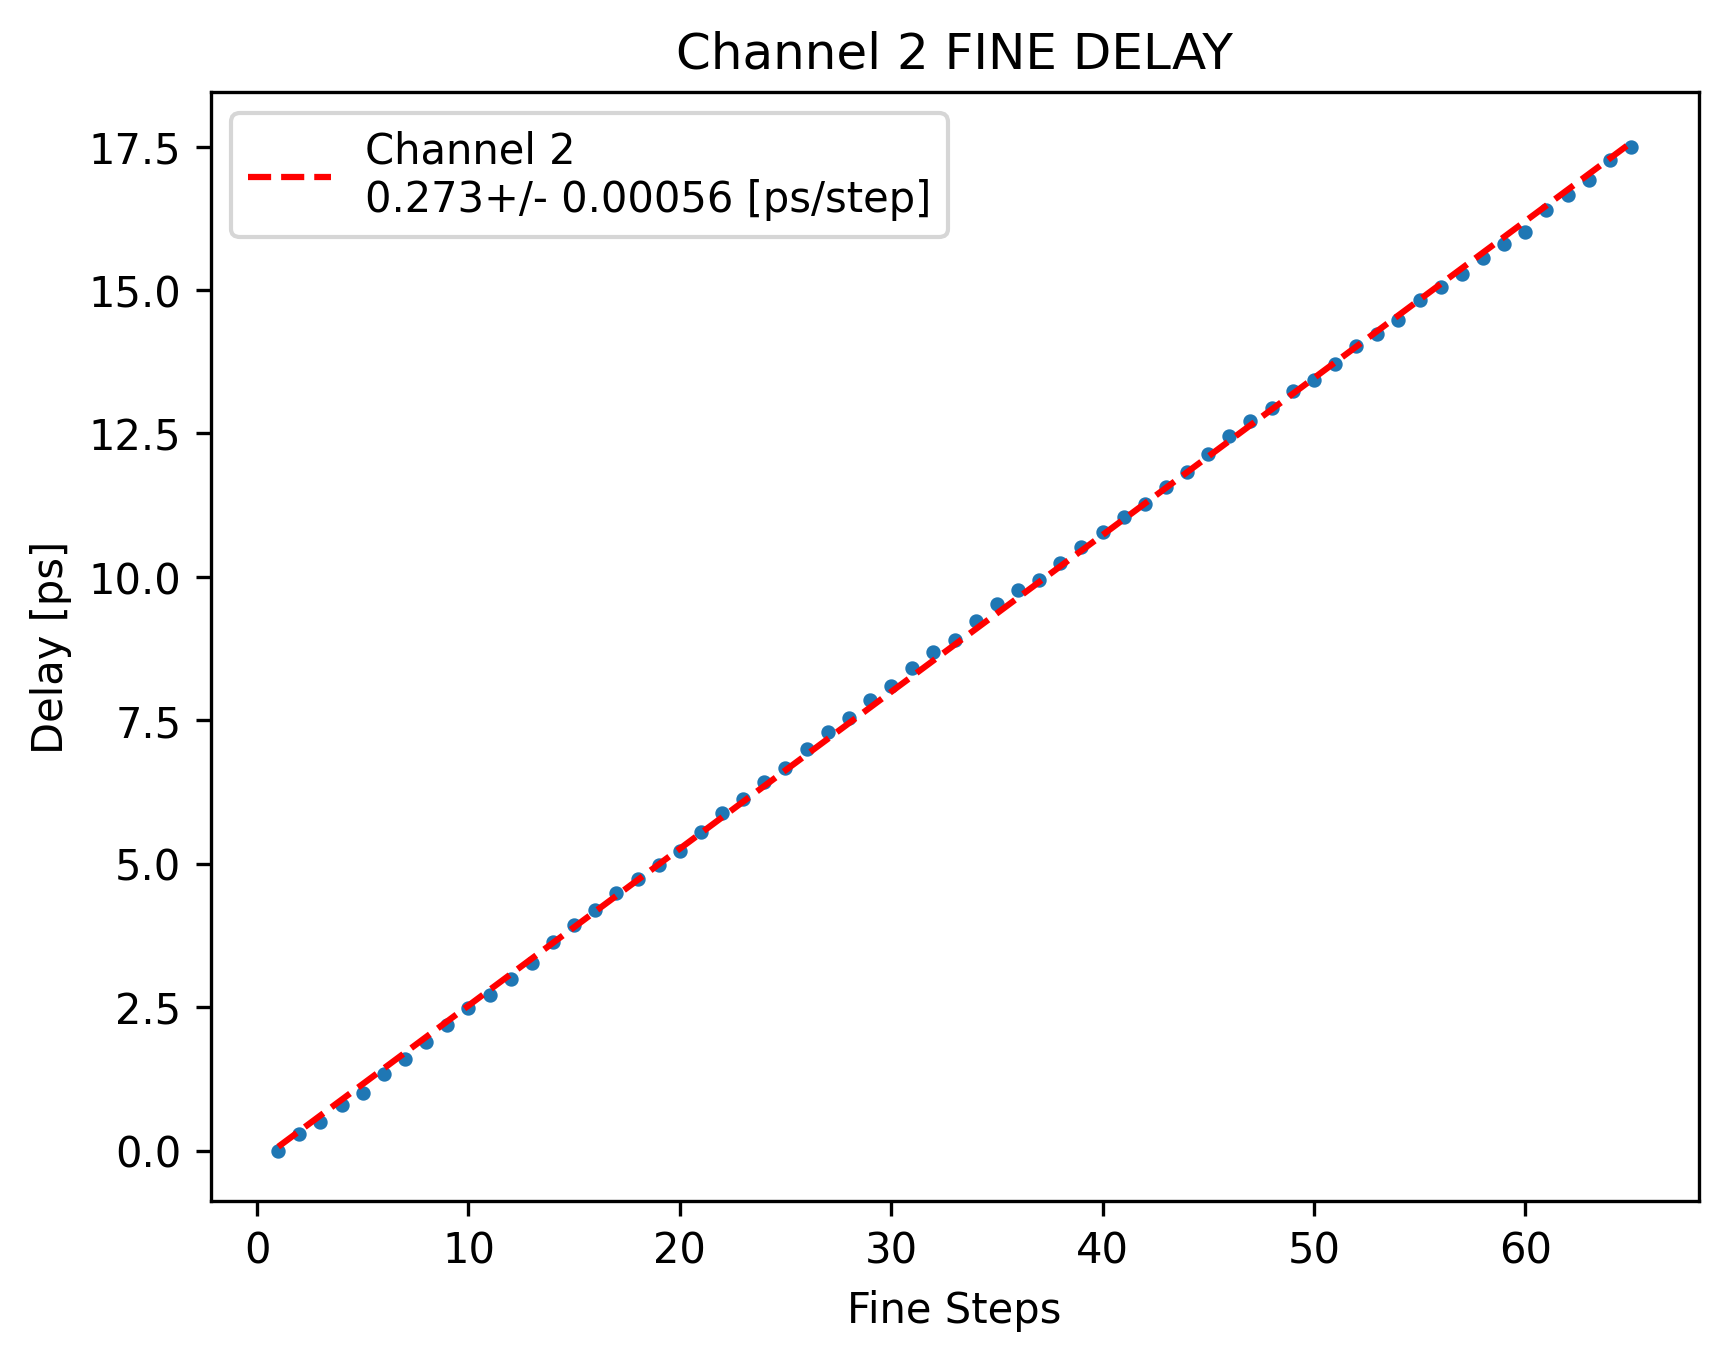

In [47]:
dat = np.asarray(dat)
x = dat.T[0]
y = -1*(dat.T[1]+200)%3125

y = y-y[0]

f,ax = plt.subplots()
# fit
popt,pcov = np.polyfit(x,y,1,cov=True)
p_e = np.sqrt(np.diag(pcov))
ax.plot(x,popt[0]*x+popt[1],color="r",linestyle='--',label=f"Channel {channel} \n{popt[0]:4.3}+/- {p_e[0]:4.2} [ps/step]")

plt.scatter(x,y,s=6)

ax.set_ylabel("Delay [ps]")
ax.set_xlabel("Fine Steps")
ax.legend(loc="upper left",fontsize=10)
ax.set_title(f"Channel {channel} FINE DELAY")
plt.savefig("dcps3Test/figures/dcps3_fine_test.png")

In [84]:
uhoh2 = []
coarse_control = 0
fine_control = 0
stage4_tune = 2
stage5_tune = 3
channel = 2
f = plt.figure(figsize=(10,4))
f.subplots_adjust(wspace=0.3)
for channel in range(2, 4, 1):
    dat2 = []
    for run in range(10):
        dat = []
        for fine_control in range(0,66,1): 
        # for fine_control in range(50,66,2):
        # for coarse_control in [0,2,4,8,16]:
            # run_name = f"f_{fine_control}"
            run_name = f"chan{channel}_f{fine_control}_c{coarse_control}_s4{stage4_tune}_s5{stage5_tune}_run{run}"
            df1 = pd.read_csv(f"{data_save_folder_fine+run_name}_ddmtd1.txt",names=['edge1','ddmtd1'])
            df2 = pd.read_csv(f"{data_save_folder_fine+run_name}_ddmtd2.txt",names=['edge2','ddmtd2'])
            df = pd.concat((df1,df2),axis=1)
            # df

            # df.ddmtd2.diff().iloc[:].plot()
            # df.ddmtd1.diff().iloc[:].plot()


            # Create a DDMTD Object for analysis of the data
            data = ddmtd(df.iloc[:,:],channel=(1,2),q=1) #creates a ddmtd object
            #Setting the correct N can recalculating all the scalings
            data.N = N  
            # data.N = 1000000 
            data.INPUT_FREQ = 160*10**6 #In Hz 
            data.Recalc()
            mean_val = np.mean(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
            #mean_val = np.mean(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
            #std_dev = np.std(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
            fit, _, _ = data.drawTIE(sep='',fit=True,draw=False)
            mean_val, std_dev = fit[1]*1000, abs(fit[2])*1000

            dat.append((fine_control, mean_val, std_dev))
        
        dat = np.asarray(dat)
        x = dat.T[0]
        y = -1*(dat.T[1]+200)%3125
        yerr = -1*(dat.T[2]+200)%3125

        if (channel == 2 and run == 6) or (channel == 3 and run == 1):
            y = y - y[1]
        else:
            y = y-y[0]

        # x = x[:(len(x) - 1)]
        # y = y[:(len(y) - 1)]

        # fig, ax = plt.subplots()
        # ax.scatter(x, y)
        # ax.set_title(f"Channel {channel} run {run}")
        
        # fit
        truth = []
        for j, val in enumerate(copy.deepcopy(y)):
            if val < 0:# or (val < 500 and channel == 3 and j == 12):
                uhoh2.append((channel, run, j))
                truth.append(False)
            else:
                truth.append(True)
        
        x = x[truth]
        y = y[truth]
        yerr = yerr[truth]

        # fig, ax = plt.subplots()
        # ax.scatter(x, y)
        # ax.set_title(f"Channel {channel} run {run}")

        popt,pcov = np.polyfit(x,y,1,cov=True,w=1/yerr**2)
        p_e = np.sqrt(np.diag(pcov))

        dat2.append((run, popt[0], p_e[0]))

        # if (run == 1 and channel == 3):
        



    dat2 = np.asarray(dat2)
    x = dat2.T[0]
    y = dat2.T[1]
    yerr = dat2.T[2]

    #print(yerr)

    weighted_mean = np.average(y, weights=1/yerr**2)
    _sig = np.std(y)

    # popt,pcov = np.polyfit(x,y,0,cov="unscaled",w=1/yerr**2)
    # p_e = np.sqrt(np.diag(pcov))

    # print(f"popt = {popt}")
    # print(f"pcov = {pcov}")
    # print(f"p_e = {p_e}")

    # weighted_mean = popt[0]
    # _sig = p_e[0]

    ax = f.add_subplot(int(f"12{channel-1}"))
    ax.grid(True, alpha=0.5)
    ax.axhline(y=weighted_mean, color='black',linewidth=1, linestyle='-.',label=f"Mean Delay Slope All Runs\n{weighted_mean:4.3}+/-{_sig:4.2} [ps/step]")
    ax.fill_between(x, weighted_mean+_sig, weighted_mean-_sig, color='orange', alpha=.5, label="\u03c3 All Runs")
    ax.errorbar(x, y, yerr=yerr, fmt='r.', ecolor="black", capsize=2, label=f"Delay per Fine Step")

    ax.set_ylim([0.265, 0.280])
    
    ax.set_ylabel("Delay per Fine Step [ps/step]")
    ax.set_xlabel("Run Number")
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(10))
    ax.legend(loc="upper left",fontsize=8)
    ax.set_title(f"Fine Delay Consistency Check\nChannel {channel}: {stage4_tune} {stage5_tune}")
plt.savefig("dcps3Test/figures/dcps3_fine_consistency_test.png", dpi=300, facecolor="#FFFFFF")
plt.close()

In [80]:
with open("./dcps3Test/data/bad_files_fine.txt", "w") as fp:
    for channel, run, fine_control in uhoh2:
        run_name = f"chan{channel}_f{fine_control}_c0_s42_s53_run{run}"
        fp.write(f"[{data_save_folder_fine+run_name}_ddmtd1.txt] is messed up\n")